# Transformer

Überwachte Implementierung der Transformer Architektur als Klassifkator

In [18]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import scipy.ndimage
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers

In [19]:
# get the working directory of the ipykernel
working_dir = os.getcwd()

# define subdirectories
data_path = os.path.join(working_dir, "data")
xy_path = os.path.join(data_path, "energy_robot_l400_s2")

In [20]:
classes = [0,1,2,3,4]
training_data_ratio = 80 # percent

x = np.load(os.path.join(xy_path, "x.npy"))
sequence_length = x.shape[1]
num_features = x.shape[2]

In [21]:
def aursad(classes=classes):
    
    x = np.load(os.path.join(xy_path, "x.npy"))
    y = np.load(os.path.join(xy_path, "y.npy"))
    sample_nr = np.load(os.path.join(xy_path, "sample_nr.npy"))
    
    # extract the relevant classes only
    mask = [i in classes for i in y]
    x = x[mask,:,:]
    y = y[mask]
    
    # split dataset into training and test data
    split = len(y) * training_data_ratio // 100
  
    rng = np.random.default_rng(0)
    
    idx = np.arange(len(y))
    rng.shuffle(idx)
    
    train_idx = idx[:split]
    test_idx = idx[split:]
    
    x_train = x[train_idx,::]
    x_test = x[test_idx,::]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    return (x_train, y_train), (x_test, y_test)

def split_dataset(x,y):
    split = len(y)*7//10
    
    rng = np.random.default_rng(0)
    
    idx = np.arange(len(y))
    rng.shuffle(idx)
    
    train_idx = idx[:split]
    test_idx = idx[split:]
    
    x_train = x[train_idx,::]
    x_test = x[test_idx,::]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    return (x_train, y_train), (x_test, y_test)
    
(x_train, y_train), (x_test, y_test) = aursad()

400
1


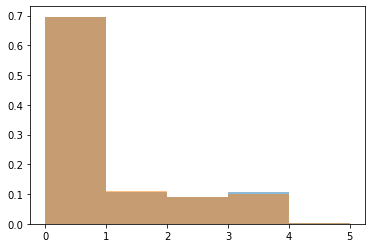

In [22]:
#y_train

plt.hist(y_train, density=True, alpha=0.5, bins=[0,1,2,3,4,5])
plt.hist(y_test, density=True, alpha=0.5, bins=[0,1,2,3,4,5])

sequence_length = x_train.shape[1]
num_features= x_train.shape[2]

print(sequence_length)
print(num_features)

In [25]:
n_classes=1

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=128,
    num_heads=2,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[32,8],
    #mlp_dropout=0.4,
    #dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",#"sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),#,learning_rate=1e-4),
    metrics="accuracy"
    #metrics="categorical_cross_entropy",#["sparse_categorical_accuracy"],
)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
layer_normalization_16 (LayerNo (None, 400, 1)       2           input_5[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_8 (MultiHe (None, 400, 1)       1793        layer_normalization_16[0][0]     
                                                                 layer_normalization_16[0][0]     
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 400, 1)       0           multi_head_attention_8[0][0

In [26]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=5)

y_train[y_train != 0] = 1
y_test[y_test != 0] = 1

print(f"Anomalies: {np.sum(y_test)}")
print(f"Total: {len(y_test)}")

print(x_train.shape)
print(y_train.shape)

model.fit(x_train, y_train, epochs=1, batch_size=64)#, validation_data=(x_test, y_test))

#p = baseline.predict(x_train).reshape(-1)
#p = p > 0.5
#print(np.sum(p==y_train)/len(p))

#baseline_classifier.fit(x_train, y_train_categorical, epochs=50, batch_size=64, validation_data=(x_test, y_test_categorical))

Anomalies: 124.0
Total: 408
(1632, 400, 1)
(1632,)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
10/26 [==========>...................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 0.3093

KeyboardInterrupt: 

In [21]:
def evaluate_model():
    
    (_,_), (xtest, ytest)  = aursad()
    
    #mask = None
    #if anomaly == None:
    #    mask = np.ones((len(y_test,)), dtype=bool)
    #else:
    #    mask = np.logical_or(y_test==7, y_test==anomaly)
    
    #x_test = x_test[mask,::]
    #y_test = y_test[mask]
    
    ytest[ytest!= 0] = 1
    actual = ytest
    
    assert np.all(ytest == y_test)
    
    predicted = baseline.predict(xtest).reshape(-1)
    predicted = predicted > 0.5
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(ytest)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')

In [22]:
evaluate_model()

TP = 89, TN = 263, FP = 21, FN = 35, N = 408
Accuracy = 0.8627450980392157, F1 = 0.7606837606837606, precision = 0.8090909090909091, recall = 0.717741935483871


In [21]:
baseline.evaluate(x_train, y_train, return_dict=True)

51/51 [==============================] - 0s 3ms/step - loss: 0.7785 - binary_accuracy: 0.6023


{'loss': 0.7784783840179443, 'binary_accuracy': 0.6023284196853638}

In [11]:
#baseline.save_weights("1DCNN-LSTM_weights.h5")

In [12]:
m2 = keras.models.load_model("1DCNN-LSTM.h5")
m2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 198, 16)           176       
_________________________________________________________________
lstm_13 (LSTM)               (None, 198, 32)           6272      
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 15,313
Trainable params: 15,313
Non-trainable params: 0
_________________________________________________________________
